# DeepLense Domain Adaptation
A PyTorch-based collection of Unsupervised Domain Adaptation methods applied to strong gravitational lenses.

This library was made with the intention of providing easy access to Unsupervised Domain Adaptation (UDA) algorithms in the context of strong gravitational lenses, though it could be also used to other kinds of images. It currently supports a normal supervised learning model:
- [Supervised](#supervised) 

And four different UDA algorithms:
- [ADDA](#adda)
- [Self-Ensemble](#se)
- [CGDM](#cgdm)
- [AdaMatch](#adamatch)

Note that different UDA algorithms will require slightly different ways of loading the data. Both Self-Ensemble and AdaMatch are very sensitive to the kind of augmentations used.

All the data used will be made available after the publication of a paper detailing our results.

# Downloading the library

In [1]:
%%capture
# ^^hides cell output
!pip install --upgrade deeplense_domain_adaptation

In [2]:
import deeplense_domain_adaptation
import torch
import matplotlib.pyplot as plt

plt.style.use('seaborn')

We'll start by defining the path to both the source and the target datasets:

In [3]:
# source domain: model_f
model_f_train_data_path = "../input/deeplense3classes-source/Data/f/f_train_data_zoom.npy"
model_f_train_labels_path = "../input/deeplense3classes-source/Data/f/f_train_labels_zoom.npy"

model_f_test_data_path = "../input/deeplense3classes-rest/Data/f/f_test_data.npy"
model_f_test_labels_path = "../input/deeplense3classes-rest/Data/f/f_test_labels.npy"

# target domain: model_j
model_j_train_data_path = "../input/deeplense3classes-rest/Data/j/j_train_data.npy"
model_j_train_labels_path = "../input/deeplense3classes-rest/Data/j/j_train_labels.npy"

model_j_test_data_path = "../input/deeplense3classes-rest/Data/j/j_test_data.npy"
model_j_test_labels_path = "../input/deeplense3classes-rest/Data/j/j_test_labels.npy"

<a id='supervised'></a>

# Supervised learning

### Loading data

We can load data using the `get_dataloader` function in `data.dataset`. There's also a `NumpyDataset` class which enables the creation of a more customized way of loading the data.

We can use the transforms available at `data.augmentations` or create custom ones. Note that if you plan on creating custom transforms, be careful that different algorithms require different kinds of augmentations. You can refer to the functions at `data.augmentations` for reference.

In [4]:
from deeplense_domain_adaptation.data import augmentations

train_transform, test_transform = augmentations.supervised_augmentations()

We then create dataloaders from our data:

In [5]:
from deeplense_domain_adaptation.data.dataset import get_dataloader

bs = 100

source_dataloader = get_dataloader(model_f_train_data_path, model_f_train_labels_path, train_transform, bs)
source_dataloader_test = get_dataloader(model_f_test_data_path, model_f_test_labels_path, test_transform, bs)

We can also plot some of our test data:

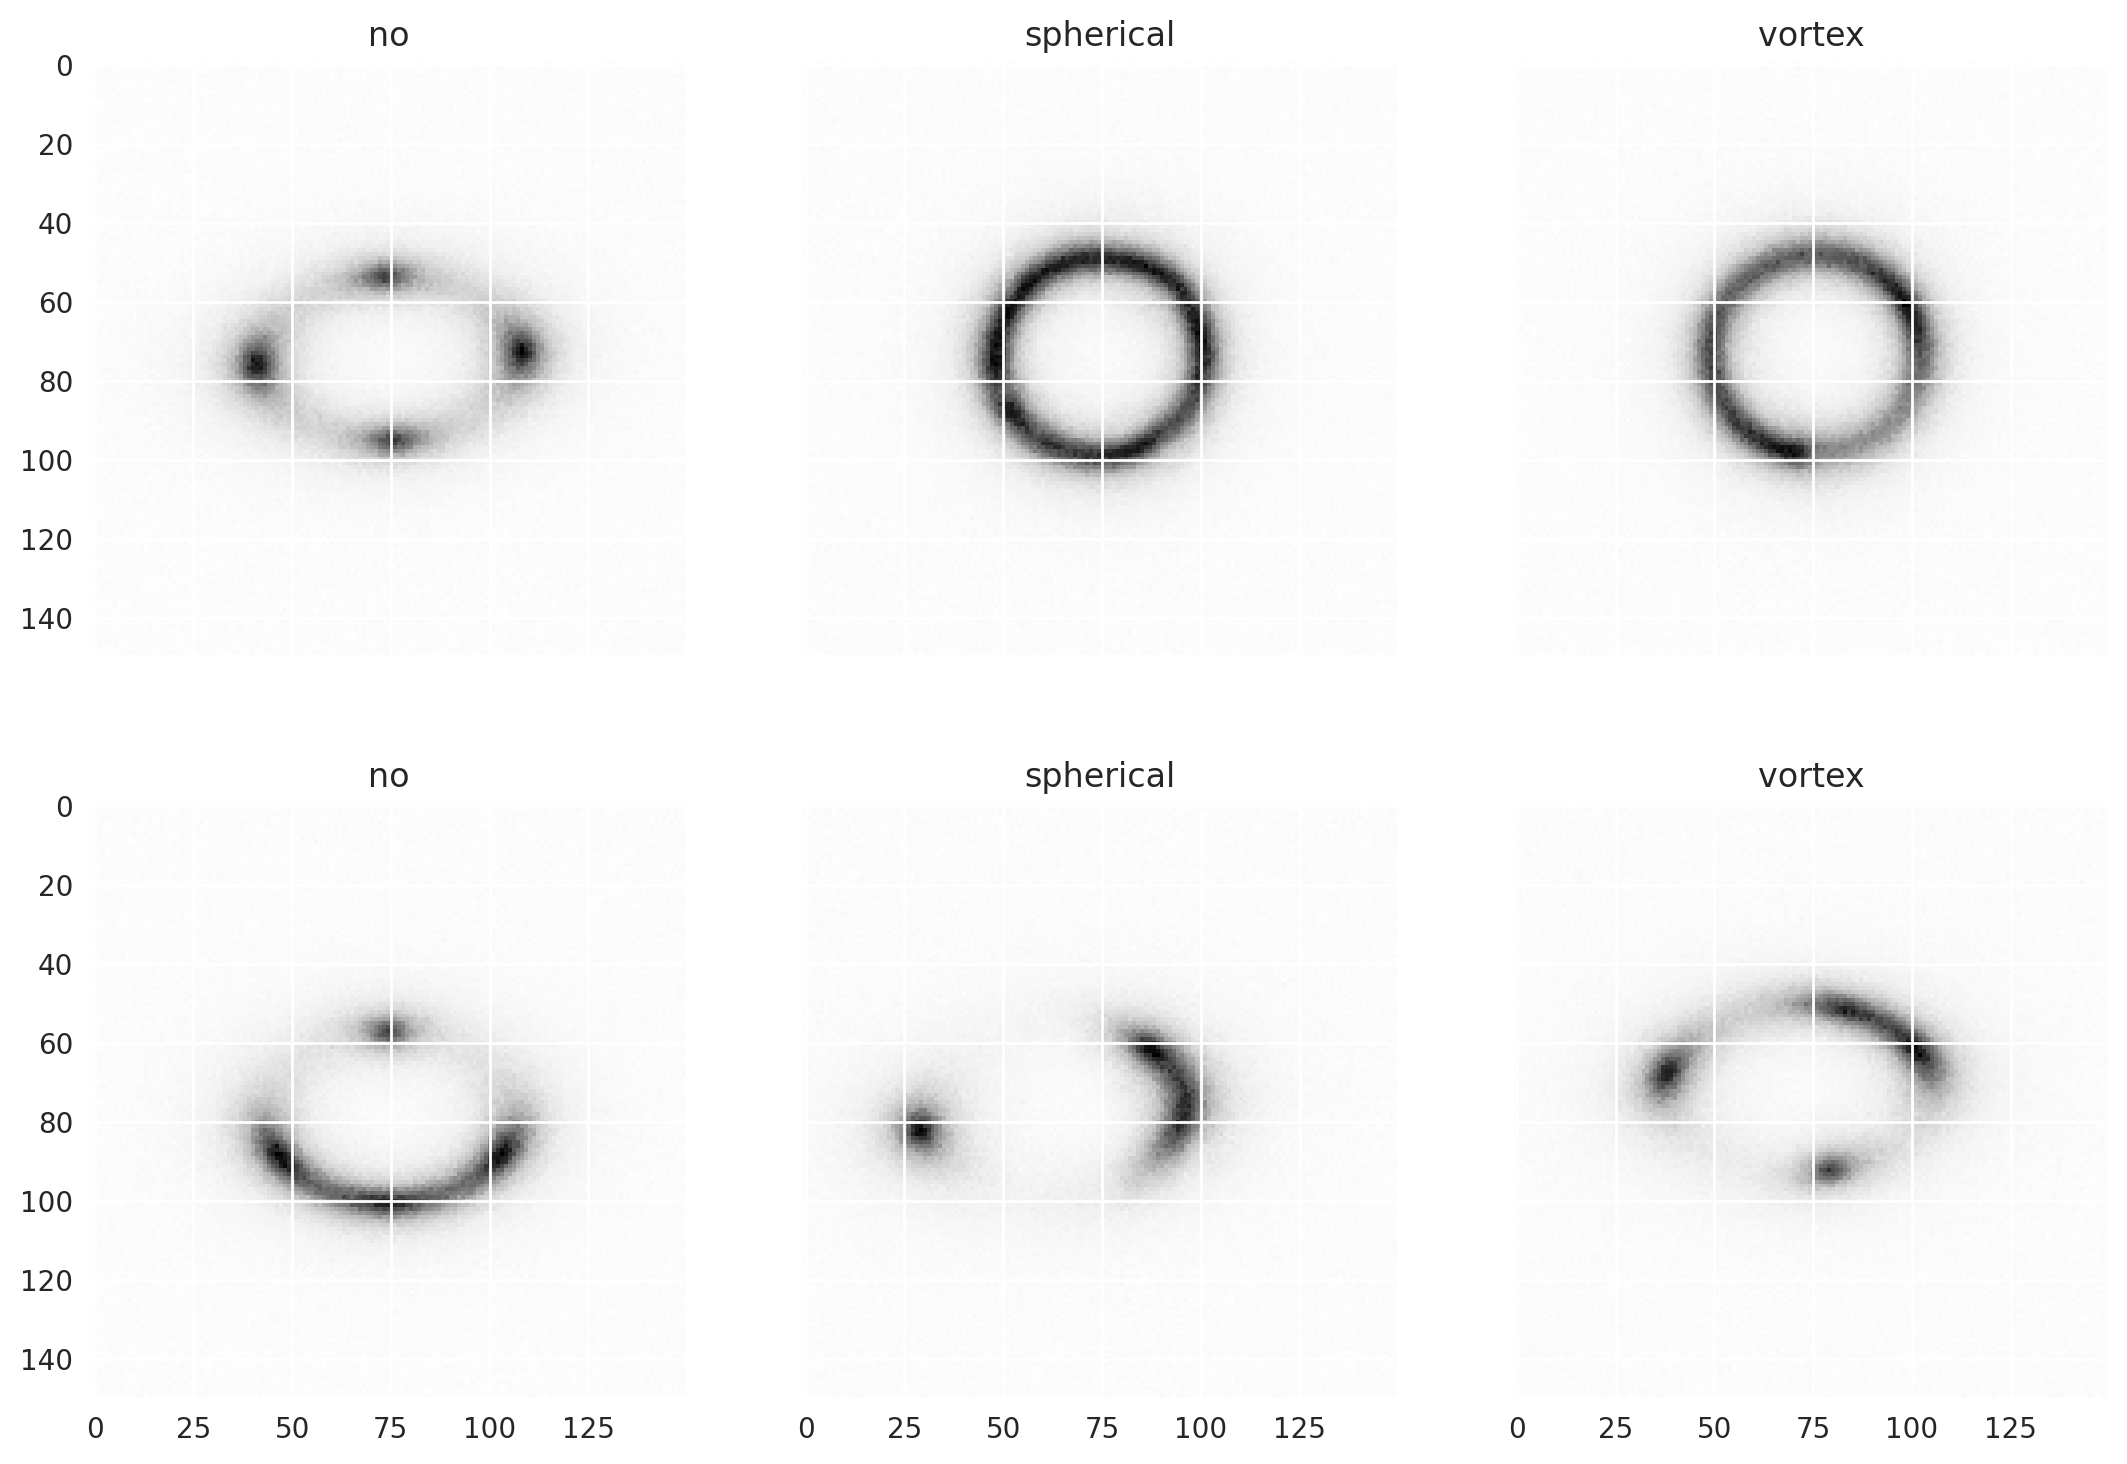

In [6]:
no = []
spherical = []
vortex = []

for imgs, labels in source_dataloader_test:
    for img, label in zip(imgs, labels):
        if len(no) > 1 and len(spherical) > 1 and len(vortex) > 1:
            break
        
        if label == 0 and len(no) < 2:
            no.append(img)
        if label == 1 and len(spherical) < 2:
            spherical.append(img)
        if label == 2 and len(vortex) < 2:
            vortex.append(img)

fig, axs = plt.subplots(2, 3, figsize=(13,9), dpi=200, sharex=True, sharey=True)

axs[0, 0].imshow(no[0][0])
axs[0, 0].set_title('no')

axs[1, 0].imshow(no[1][0])
axs[1, 0].set_title('no')

axs[0, 1].imshow(spherical[0][0])
axs[0, 1].set_title('spherical')

axs[1, 1].imshow(spherical[1][0])
axs[1, 1].set_title('spherical')

axs[0, 2].imshow(vortex[0][0])
axs[0, 2].set_title('vortex')

axs[1, 2].imshow(vortex[1][0])
axs[1, 2].set_title('vortex')


plt.show()

### Setting up model
In order to set up our model we need to get network that we'll be using (from `networks.*`), the hyperparameters for our algorithms (from `data.hyperparams`) and then call the algorithm class (from `algorithms.*`).

First we'll call the encoder and classifier. In this example we'll be using the ResNet architecture, but it's the same process for other architectures. Just notice that in order to use the Equivariant Neural Network architecture it is necessary to downgrade torch to 1.4 and torchvision to 0.5!

In [7]:
from deeplense_domain_adaptation.networks import resnet

encoder = resnet.Encoder('18')
classifier = resnet.Classifier()

Then we get the hyperparameters for the algorithm we'll use:

In [8]:
from deeplense_domain_adaptation.data import hyperparams

hparams = hyperparams.supervised_hyperparams()

And finally we'll call the algorithm class and set it up:

In [9]:
from deeplense_domain_adaptation.algorithms import supervised

supervised = supervised.Supervised(encoder, classifier)

### Train and evaluate the model
Now we have everything we need to train and evaluate our model.

When training the model, you can set the epochs to be a pretty large number since there's an early stopping implementation. If the accuracy of the model on the validation set (`dataloader_test`) doesn't improve in more than 15 epochs, training will stop.

`save_path` is where the encoder and classifier weights will be saved, so that they can be loaded afterwards. To prevent saving an overfitted model, the algorithm will save only the model that had the best accuracy on the validation set.

In [ ]:
epochs = 100
save_path = "./supervised.pt"

encoder, classifier = supervised.train(source_dataloader, source_dataloader_test, epochs, hparams, save_path)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[Epoch 1/100] loss: 1.100630; accuracy: 0.363033; val accuracy: 0.337867;
[Epoch 2/100] loss: 1.088824; accuracy: 0.347733; val accuracy: 0.403067;
[Epoch 3/100] loss: 1.073363; accuracy: 0.420733; val accuracy: 0.333200;
[Epoch 4/100] loss: 1.047639; accuracy: 0.426300; val accuracy: 0.339200;
[Epoch 5/100] loss: 1.009708; accuracy: 0.333600; val accuracy: 0.333333;
[Epoch 6/100] loss: 0.957721; accuracy: 0.447933; val accuracy: 0.478533;
[Epoch 7/100] loss: 0.870707; accuracy: 0.509000; val accuracy: 0.502800;
[Epoch 8/100] loss: 0.800476; accuracy: 0.395100; val accuracy: 0.337333;
[Epoch 9/100] loss: 0.714828; accuracy: 0.463900; val accuracy: 0.364800;
[Epoch 10/100] loss: 0.611145; accuracy: 0.599267; val accuracy: 0.448800;
[Epoch 11/100] loss: 0.523646; accuracy: 0.675033; val accuracy: 0.496933;
[Epoch 12/100] loss: 0.445561; accuracy: 0.813100; val accuracy: 0.781733;
[Epoch 13/100] loss: 0.367245; accuracy: 0.811867; val accuracy: 0.828533;
[Epoch 14/100] loss: 0.304230; acc

We can then print the model's training metrics:

In [ ]:
supervised.plot_metrics()

And evaluate it on the test set:

In [ ]:
# returns accuracy on the test set
print(f"accuracy on test set = {supervised.evaluate(source_dataloader_test)}")

# returns a confusion matrix plot and a ROC curve plot (that also shows the AUROC)
supervised.plot_cm_roc(source_dataloader_test)

<a id='adda'></a>

# ADDA
ADDA (from **Adversarial Discriminative Domain Adaptation** by _Eric Tzeng, Judy Hoffman, Kate Saenko, Trevor Darrell_) is an adversarial domain adaptation method, where the goal is to minimize the domain discrepancy distance through an adversarial objective with respect to a discriminator. 

We want the discriminator to be unable to distinguish between the source and the target distributions!

ADDA learns a discriminative representations using the labels in the source domain and then a separate encoding that maps the target data to the same space. Our goal is to fool the domain discriminator so that it is unable to distinguish the source from the target.

In order to train ADDA, we must use the encoder and classifier trained on the source as initial inputs. In more practical terms: we must use the encoder and classifier that were trained with `Supervised`. While this is the only algorithm that **needs** this kind of transfer learning, this technique is beneficial to the other algorithms, which is the reason we'll be using it.

### Loading data
Since we'll apply a UDA algorithm, we'll need to load both the source and the target domain data. We found that, on our data, it's beneficial to apply different transforms to the source and the target data. Applying random zoom transforms to the source data, for example, helps improve the performance on the target dataset. In this example we're not going to use this since the source dataset has been already modified to have random zoom augmentations.

In [ ]:
from deeplense_domain_adaptation.data import augmentations

train_transform_source, train_transform_target, test_transform = augmentations.adda_augmentations()

Now we create the dataloaders:

In [ ]:
from deeplense_domain_adaptation.data.dataset import get_dataloader

bs = 100

source_dataloader = get_dataloader(model_f_train_data_path, model_f_train_labels_path, train_transform_source, bs)
source_dataloader_test = get_dataloader(model_f_test_data_path, model_f_test_labels_path, test_transform, bs)

target_dataloader = get_dataloader(model_j_train_data_path, model_j_train_labels_path, train_transform_target, bs)
target_dataloader_test = get_dataloader(model_j_test_data_path, model_j_test_labels_path, test_transform, bs)

### Setting up model
For ADDA we need to use a discriminator network.

We'll load the encoder and classifier weights from our model trained on a supervised manner on the source dataset:

In [ ]:
from deeplense_domain_adaptation.networks import resnet
from deeplense_domain_adaptation.networks import discriminator

source_encoder = resnet.Encoder('18')
target_encoder = resnet.Encoder('18')
classifier = resnet.Classifier()
discriminator = discriminator.Discriminator()

supervised_path = "./supervised.pt"
supervised_weights = torch.load(supervised_path)

source_encoder.load_state_dict(supervised_weights['encoder_weights'])
classifier.load_state_dict(supervised_weights['classifier_weights'])

Get the hyperparameters for ADDA:

In [ ]:
from deeplense_domain_adaptation.data import hyperparams

hparams = hyperparams.adda_hyperparams()

Instantiate ADDA:

In [ ]:
from deeplense_domain_adaptation.algorithms import adda

adda = adda.Adda(source_encoder, target_encoder, classifier, discriminator)

### Train and evaluate the model
Now we have everything we need to train and evaluate our model.

Just like `Supervised`, the UDA algorithms also have early stopping. The difference is that we measure the accuracy of the model on the target dataset validation set (`target_dataloader_test`).

In [ ]:
epochs = 100
save_path = "./adda.pt"

encoder, classifier = adda.train(source_dataloader, target_dataloader, target_dataloader_test, epochs, hparams, save_path)

We can then print the model's training metrics:

In [ ]:
adda.plot_metrics()

And evaluate it on the test set:

In [ ]:
# returns accuracy on the test set
print(f"accuracy on test set = {adda.evaluate(target_dataloader_test)}")

# returns a confusion matrix plot and a ROC curve plot (that also shows the AUROC)
adda.plot_cm_roc(target_dataloader_test)

<a id='se'></a>

# Self-Ensemble
Self-Ensemble (from **Self-ensembling for visual domain adaptation** by _Geoffrey French, Michal Mackiewicz, Mark Fisher_) is based off of the mean teacher model used in semi-supervised learning. The mean teacher model has two networks: a student (trained with gradient descent) and a teacher (weights are an exponential moving average of the student's weights).

In order to train Self-Ensemble we do not need to use transfer learning from the encoder and classifier trained on `Supervised`. From our tests though, this seems to improve the performance of the model.

### Loading data

In [ ]:
from deeplense_domain_adaptation.data import augmentations

train_transform_source, train_transform_target, test_transform = augmentations.self_ensemble_augmentations()

In [ ]:
from deeplense_domain_adaptation.data.dataset import get_dataloader

bs = 100

source_dataloader = get_dataloader(model_f_train_data_path, model_f_train_labels_path, train_transform_source, bs)
source_dataloader_test = get_dataloader(model_f_test_data_path, model_f_test_labels_path, test_transform, bs)

target_dataloader = get_dataloader(model_j_train_data_path, model_j_train_labels_path, train_transform_target, bs)
target_dataloader_test = get_dataloader(model_j_test_data_path, model_j_test_labels_path, test_transform, bs)

### Setting up model
We'll load the encoder and classifier weights from our model trained on a supervised manner on the source dataset:

In [ ]:
from deeplense_domain_adaptation.networks import resnet

student_encoder = resnet.Encoder('18')
student_classifier = resnet.Classifier()
teacher_encoder = resnet.Encoder('18')
teacher_classifier = resnet.Classifier()

supervised_path = "./supervised.pt"
supervised_weights = torch.load(supervised_path)

student_encoder.load_state_dict(supervised_weights['encoder_weights'])
student_classifier.load_state_dict(supervised_weights['classifier_weights'])

Get the hyperparameters for Self-Ensemble:

In [ ]:
from deeplense_domain_adaptation.data import hyperparams

hparams = hyperparams.self_ensemble_hyperparams()

Instantiate Self-Ensemble:

In [ ]:
from deeplense_domain_adaptation.algorithms import self_ensemble

self_ensemble = self_ensemble.SelfEnsemble(student_encoder, student_classifier, teacher_encoder, teacher_classifier)

### Train and evaluate the model
Now we have everything we need to train and evaluate our model.

In [ ]:
epochs = 100
save_path = "./self_ensemble.pt"

encoder, classifier = self_ensemble.train(source_dataloader, target_dataloader, target_dataloader_test, epochs, hparams, save_path)

We can then print the model's training metrics:

In [ ]:
self_ensemble.plot_metrics()

And evaluate it on the test set:

In [ ]:
# returns accuracy on the test set
print(f"accuracy on test set = {self_ensemble.evaluate(target_dataloader_test)}")

# returns a confusion matrix plot and a ROC curve plot (that also shows the AUROC)
self_ensemble.plot_cm_roc(target_dataloader_test)

<a id='cgdm'></a>

# CGDM
CGDM (from **Cross-Domain Gradient Discrepancy Minimization for Unsupervised Domain Adaptation** by _Zhekai Du, Jingjing Li, Hongzu Su, Lei Zhu, Ke Lu_) is a bi-classifier adversarial learning method.

CGDM minimizes the discrepancy of gradients generated by source and target samples. To compute the gradients of the target samples, it uses a clustering-based strategy to obtain more reliable pseudo-labels. It then uses self-supervised learning on the pseudo-labels in order to optimize the model with data from the source and the target domain.

Given its bi-classifier nature, after training CGDM we'll obtain an encoder and two classifiers, that are used together when evaluating a new data point.

In order to train CGDM we do not need to use transfer learning from the encoder and classifier trained on `Supervised`. From our tests though, this seems to improve the performance of the model.

### Loading data

In [ ]:
from deeplense_domain_adaptation.data import augmentations

train_transform_source, train_transform_target, test_transform = augmentations.cgdm_augmentations()

In [ ]:
from deeplense_domain_adaptation.data.dataset import get_dataloader

bs = 100

source_dataloader = get_dataloader(model_f_train_data_path, model_f_train_labels_path, train_transform_source, bs)
source_dataloader_test = get_dataloader(model_f_test_data_path, model_f_test_labels_path, test_transform, bs)

target_dataloader = get_dataloader(model_j_train_data_path, model_j_train_labels_path, train_transform_target, bs)
target_dataloader_test = get_dataloader(model_j_test_data_path, model_j_test_labels_path, test_transform, bs)

### Setting up model
We'll load the encoder and classifier weights from our model trained on a supervised manner on the source dataset:

In [ ]:
from deeplense_domain_adaptation.networks import resnet

encoder = resnet.Encoder('18')
classifier1 = resnet.Classifier()
classifier2 = resnet.Classifier()

supervised_path = "./supervised.pt"
supervised_weights = torch.load(supervised_path)

encoder.load_state_dict(supervised_weights['encoder_weights'])
classifier1.load_state_dict(supervised_weights['classifier_weights'])
classifier2.load_state_dict(supervised_weights['classifier_weights'])

Get the hyperparameters for CGDM:

In [ ]:
from deeplense_domain_adaptation.data import hyperparams

hparams = hyperparams.cgdm_hyperparams()

Instantiate CGDM:

In [ ]:
from deeplense_domain_adaptation.algorithms import cgdm

cgdm = cgdm.Cgdm(encoder, classifier1, classifier2)

### Train and evaluate the model
Now we have everything we need to train and evaluate our model.

In [ ]:
epochs = 100
save_path = "./cgdm.pt"

encoder, classifier1, classifier2 = cgdm.train(source_dataloader, target_dataloader, target_dataloader_test, epochs, hparams, save_path)

We can then print the model's training metrics:

In [ ]:
cgdm.plot_metrics()

And evaluate it on the test set:

In [ ]:
# returns accuracy on the test set
print(f"accuracy on test set = {cgdm.evaluate(target_dataloader_test)}")

# returns a confusion matrix plot and a ROC curve plot (that also shows the AUROC)
cgdm.plot_cm_roc(target_dataloader_test)

<a id='adamatch'></a>

# AdaMatch
AdaMatch (from **AdaMatch: A Unified Approach to Semi-Supervised Learning and Domain Adaptation** by _David Berthelot, Rebecca Roelofs, Kihyuk Sohn, Nicholas Carlini, Alex Kurakin_) is a novel method that unifies UDA with semi-supervised learning and semi-supervised domain adaptation.

This method augments each image twice, once with a weak augmentation and once with a strong augmentation. From those images we're able to extract logits, that are randomly interpolated. It then performs a distribution allignment to find target pseudo-labels.

In order to train AdaMatch we do not need to use transfer learning from the encoder and classifier trained on `Supervised`. From our tests though, this seems to improve the performance of the model.

### Loading data

The weak and strong augmentations are a very important hyperparameter to find. It's important to use strong augmentations that aren't strong enough as to modify the data too much, but also not weak enough as to make the images too similar to how they were originally.

In [ ]:
from deeplense_domain_adaptation.data import augmentations

train_transform_source_weak, train_transform_target_weak, train_transform_source_strong, train_transform_target_strong, test_transform = augmentations.adamatch_augmentations()

When creating the dataloaders we make the batch size for the target dataset be 3 times the batch size of the source dataset:

In [ ]:
from deeplense_domain_adaptation.data.dataset import get_dataloader

bs = 100
bs_target = 3 * bs

source_dataloader_train_weak = get_dataloader(model_f_train_data_path, model_f_train_labels_path, train_transform_source_weak, bs)
source_dataloader_train_strong = get_dataloader(model_f_train_data_path, model_f_train_labels_path, train_transform_source_strong, bs)
source_dataloader_test = get_dataloader(model_f_test_data_path, model_f_test_labels_path, test_transform, bs)

target_dataloader_train_weak = get_dataloader(model_j_train_data_path, model_j_train_labels_path, train_transform_target_weak, bs_target)
target_dataloader_train_strong = get_dataloader(model_j_train_data_path, model_j_train_labels_path, train_transform_target_strong, bs_target)
target_dataloader_test = get_dataloader(model_j_test_data_path, model_j_test_labels_path, test_transform, bs_target)

### Setting up model
We'll load the encoder and classifier weights from our model trained on a supervised manner on the source dataset:

In [ ]:
from deeplense_domain_adaptation.networks import resnet

encoder = resnet.Encoder('18')
classifier = resnet.Classifier()

supervised_path = "/supervised.pt"
supervised_weights = torch.load(supervised_path)

encoder.load_state_dict(supervised_weights['encoder_weights'])
classifier.load_state_dict(supervised_weights['classifier_weights'])

Get the hyperparameters for AdaMatch:

In [ ]:
from deeplense_domain_adaptation.data import hyperparams

hparams = hyperparams.adamatch_hyperparams()

Instantiate AdaMatch:

In [ ]:
from deeplense_domain_adaptation.algorithms import adamatch

adamatch = adamatch.Adamatch(encoder, classifier)

### Train and evaluate the model
Now we have everything we need to train and evaluate our model.

In [ ]:
epochs = 100
save_path = "./adamatch.pt"

encoder, classifier = adamatch.train(source_dataloader_train_weak, source_dataloader_train_strong,
                                     target_dataloader_train_weak, target_dataloader_train_strong, target_dataloader_test,
                                     epochs, hparams, save_path)

We can then print the model's training metrics:

In [ ]:
adamatch.plot_metrics()

And evaluate it on the test set:

In [ ]:
# returns accuracy on the test set
print(f"accuracy on test set = {adamatch.evaluate(target_dataloader_test)}")

# returns a confusion matrix plot and a ROC curve plot (that also shows the AUROC)
adamatch.plot_cm_roc(target_dataloader_test)